# Notebook to reproduce the results in *Evolutionary dynamics in finite populations can explain the full range of cooperative behaviors observed in the centipede game* by David G. Rand & Martin A. Nowak (2012)

Useful references:
- Rand & Nowak, 2012 https://www.sciencedirect.com/science/article/pii/S0022519312000124
- McKelvey & Palfrey, 1992 https://www.jstor.org/stable/2951567
- Domingos, Santos & Lenaerts, 2023 https://www.cell.com/iscience/fulltext/S2589-0042(23)00496-0

## Libraries

This notebook mostly relies on numpy and egttools.

Then we use matplotlib for plotting the results
Networkx is only used to plot the payoff structure.

In [1]:
#!pip install egttools

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import networkx as nx

from egttools.games import Matrix2PlayerGameHolder
from egttools.utils import calculate_stationary_distribution
from egttools.analytical import PairwiseComparison
from egttools.numerical import PairwiseComparisonNumerical
from egttools.numerical.numerical_ import calculate_strategies_distribution

## Parameters of this notebook

In [3]:
# Parameters of the notebook

NB_STEPS = 6 # length of the centipede game: in the original paper NB_STEPS is either 4 or 6
A1 = .4 # payoff of Player 1 at the first step 
A0 = .1 # payoff of Player 2 at the first step
B = 2 # multiplicative factor of the payoffs

NB_DATAPOINTS = 10 # granularity of our results
Z=1000 # population size

# experimental reference from McKelvey & Palfrey, 1992
if A1 == .4 and A0 == .1 and B == 2:
    if NB_STEPS==6:
        experimental_reference = np.array([0.007, 0.064, 0.199, 0.384, 0.253, 0.078, 0.014], dtype = float)
        session1 = np.array([.02, .09, .39, .28, .20, .01, .01], dtype = float)
        session2 = np.array([0, .02, .04, .46, .35, .11, .02], dtype = float)
        session3 = np.array([0, .07, .14, .43, .23, .12, .01], dtype = float)
    elif NB_STEPS==4:
        experimental_reference = np.array([0.071, 0.356, 0.370, 0.153, 0.049], dtype = float)
        session1 = np.array([.06, .26, .44, .2, .04], dtype = float)
        session2 = np.array([.10, .38, .40, .11, .01], dtype = float)
        session3 = np.array([.06, .43, .28, .14, .09], dtype = float)


## Functions to produce payoffs and payoff matrix for the Centipede Game

Note that the Centipede Game in normal form is an asymmetric game, but in Rand & Nowak, 2012 they make it symmetric with the assumption that each player can be either Player 1 or Player 2 with equal probability.

In [4]:
def get_payoffs(nb_steps : int,
                payoff_step0_pl1 : float, 
                payoff_step0_pl2 : float,
                multiplicative_factor : float,
               ):
    payoffs_pl1 = np.tile([payoff_step0_pl1, payoff_step0_pl2], nb_steps//2) * multiplicative_factor**np.arange(nb_steps, dtype=float)
    payoffs_pl2 = np.tile([payoff_step0_pl2, payoff_step0_pl1], nb_steps//2) * multiplicative_factor**np.arange(nb_steps, dtype=float)

    # add payoffs in final node
    payoffs_pl1 = np.append(payoffs_pl1, payoff_step0_pl1 * multiplicative_factor ** nb_steps)
    payoffs_pl2 = np.append(payoffs_pl2, payoff_step0_pl2 * multiplicative_factor ** nb_steps)

    return payoffs_pl1, payoffs_pl2

def get_payoff_matrix_asymmetric(payoffs_pl1 : np.ndarray,
                                 payoffs_pl2 : np.ndarray,
                                ):
    assert len(payoffs_pl1) == len(payoffs_pl2)
    nb_steps = len(payoffs_pl1) - 1
    nb_actions = nb_steps // 2 + 1
    payoff_matrix = np.zeros((nb_actions, nb_actions, 2), dtype=float)

    for i in range(nb_actions):
        for j in range(nb_actions):
            take = min(min(2*i, nb_steps), min(2*j + 1, nb_steps))
            payoff_matrix[i,j, 0] = payoffs_pl1[take]
            payoff_matrix[i,j, 1] = payoffs_pl2[take]
            
    return payoff_matrix

def get_payoff_matrix_symmetric(payoffs_pl1 : np.ndarray,
                                payoffs_pl2 : np.ndarray,
                               ):
    assert len(payoffs_pl1) == len(payoffs_pl2)
    dim = len(payoffs_pl1)
    nb_steps = dim-1
    payoff_matrix = np.zeros((dim, dim), dtype=float)

    for i in range(dim):
        for j in range(dim):
            # case A: row player = Player 1, column player = Player 2
            take_pl1 = i
            take_pl2 = j
            # adjust:
            if i % 2 != 0 and i < nb_steps:
                take_pl1+=1
            if j % 2 == 0 and j < nb_steps: 
                take_pl2+=1
                
            payoff_matrix[i, j] += payoffs_pl1[min(take_pl1, take_pl2)]

            # case B: row player = Player 2, column player = Player 1
            take_pl2 = i
            take_pl1 = j
            # adjust:
            if i % 2 == 0 and i < nb_steps:
                take_pl2+=1
            if j % 2 != 0 and j < nb_steps: 
                take_pl1+=1
                
            payoff_matrix[i, j] += payoffs_pl2[min(take_pl1, take_pl2)]

    # divide by 2 to normalize
    return .5 * payoff_matrix

## Structure of the game (Figure 1)
We use the library Networkx

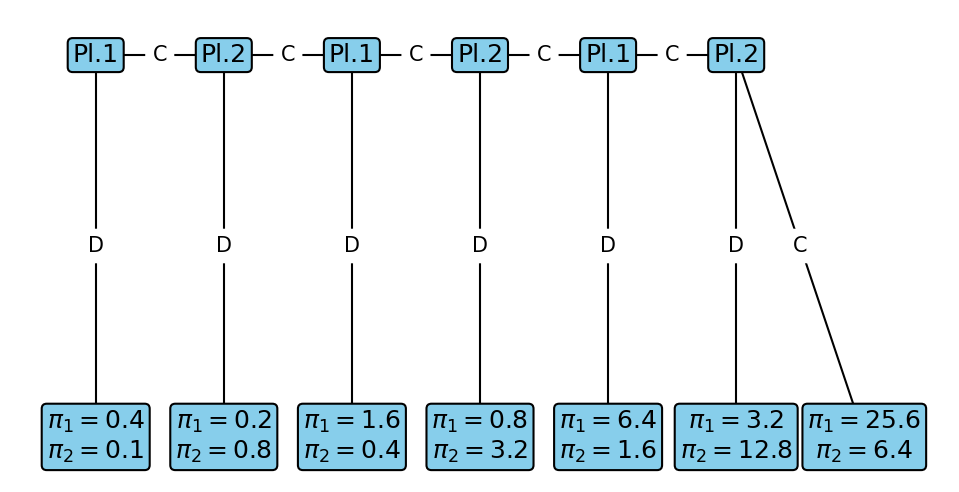

In [5]:
p_pl1, p_pl2 = get_payoffs(6, A1, A0, B)

G = nx.path_graph(7)
G.add_nodes_from([7, 8, 9, 10, 11, 12])
G.add_edges_from([(0,7), (1,8), (2,9), (3,10), (4,11), (5,12)])

pos = nx.planar_layout(G)
pos[0]=np.array([-2,2])
pos[1]=np.array([-1,2])
pos[2]=np.array([0,2])
pos[3]=np.array([1,2])
pos[4]=np.array([2,2])
pos[5]=np.array([3,2])
pos[6]=np.array([4,1])

pos[7]=np.array([-2,1])
pos[8]=np.array([-1,1])
pos[9]=np.array([0,1])
pos[10]=np.array([1,1])
pos[11]=np.array([2,1])
pos[12]=np.array([3,1])

labeldict={}
labeldict[0]="Pl.1"
labeldict[2]="Pl.1"
labeldict[4]="Pl.1"
labeldict[1]="Pl.2"
labeldict[3]="Pl.2"
labeldict[5]="Pl.2"

labeldict[7]=r"$\pi_1=$"+str(p_pl1[0])+"\n"+r"$\pi_2=$"+str(p_pl2[0])
labeldict[8]=r"$\pi_1=$"+str(p_pl1[1])+"\n"+r"$\pi_2=$"+str(p_pl2[1])
labeldict[9]=r"$\pi_1=$"+str(p_pl1[2])+"\n"+r"$\pi_2=$"+str(p_pl2[2])
labeldict[10]=r"$\pi_1=$"+str(p_pl1[3])+"\n"+r"$\pi_2=$"+str(p_pl2[3])
labeldict[11]=r"$\pi_1=$"+str(p_pl1[4])+"\n"+r"$\pi_2=$"+str(p_pl2[4])
labeldict[12]=r"$\pi_1=$"+str(p_pl1[5])+"\n"+r"$\pi_2=$"+str(p_pl2[5])
labeldict[6]=r"$\pi_1=$"+str(p_pl1[6])+"\n"+r"$\pi_2=$"+str(p_pl2[6])

edge_labels={(0,1): "C",
             (1,2): "C",
             (2,3): "C",
             (3,4): "C",
             (4,5): "C",
             (5,6): "C",
             (0,7): "D",
             (1,8): "D",
             (2,9): "D",
             (3,10): "D",
             (4,11): "D",
             (5,12): "D",
            }

if NB_STEPS==4: #this adapts the graph to the case where NB_STEPS=4
    G.add_edge(3,11)
    G.remove_nodes_from([4, 5, 6, 12])
    labeldict.pop(4)
    edge_labels.pop((3,4))
    edge_labels[(4,11)]="C"


fig, ax = plt.subplots(figsize= (8,4), dpi=150)
ax=nx.draw(G, 
        pos=pos, 
        with_labels=True, 
        labels=labeldict,
        node_shape="s",  
        node_color="none", 
        bbox=dict(facecolor="skyblue", edgecolor='black', boxstyle='round,pad=0.2'),
       )
ax=nx.draw_networkx_edge_labels(
        G, 
        pos,
        edge_labels=edge_labels,
        rotate=False,
)
plt.axis('off')
plt.show() # display

In [6]:
payoffs_pl1, payoffs_pl2 = get_payoffs(NB_STEPS, A1, A0, B)
payoff_matrix_asymmetric = get_payoff_matrix_asymmetric(payoffs_pl1, payoffs_pl2)
payoff_matrix = get_payoff_matrix_symmetric(payoffs_pl1, payoffs_pl2)
nb_strategies = len(payoff_matrix)

In [7]:
print('Payoffs of Player 1:', payoffs_pl1)
print('Payoffs of Player 2:', payoffs_pl2)
print('Payoff matrix of Player 1:\n', payoff_matrix_asymmetric[:,:,0])
print('Payoff matrix of Player 2:\n', payoff_matrix_asymmetric[:,:,1])
print('Payoff matrix of Rand & Nowak, 2012:\n', payoff_matrix)

Payoffs of Player 1: [ 0.4  0.2  1.6  0.8  6.4  3.2 25.6]
Payoffs of Player 2: [ 0.1  0.8  0.4  3.2  1.6 12.8  6.4]
Payoff matrix of Player 1:
 [[ 0.4  0.4  0.4  0.4]
 [ 0.2  1.6  1.6  1.6]
 [ 0.2  0.8  6.4  6.4]
 [ 0.2  0.8  3.2 25.6]]
Payoff matrix of Player 2:
 [[ 0.1  0.1  0.1  0.1]
 [ 0.8  0.4  0.4  0.4]
 [ 0.8  3.2  1.6  1.6]
 [ 0.8  3.2 12.8  6.4]]
Payoff matrix of Rand & Nowak, 2012:
 [[ 0.25  0.6   0.6   0.6   0.6   0.6   0.6 ]
 [ 0.15  0.5   1.2   1.2   1.2   1.2   1.2 ]
 [ 0.15  0.3   1.    2.4   2.4   2.4   2.4 ]
 [ 0.15  0.3   0.6   2.    4.8   4.8   4.8 ]
 [ 0.15  0.3   0.6   1.2   4.    9.6   9.6 ]
 [ 0.15  0.3   0.6   1.2   2.4   8.   19.2 ]
 [ 0.15  0.3   0.6   1.2   2.4   4.8  16.  ]]


## Decreasing the selection strength favors increasingly cooperative strategies - Figure 2

EGTTools utilizes a slightly different way to compute the fitness (aka Fermi function) where $\beta$ can range from 0 to $+\inf$

In Rand & Nowak, 2012, instead they utilize the formula $\text{fitness} = 1 - \beta + \beta*\text{payoff}$ where $\beta$ can range from 0 to 1

In [8]:
# Parameters

betas = np.logspace(-5., 1., NB_DATAPOINTS) 

In [9]:
game = Matrix2PlayerGameHolder(nb_strategies, payoff_matrix)
evolver = PairwiseComparison(population_size=Z, game=game)

stationary_distributions = np.zeros((NB_DATAPOINTS, nb_strategies), dtype=float)

for i, beta in enumerate(betas):
    transition_matrix, _ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
    stationary_distributions[i,:] = calculate_stationary_distribution(transition_matrix.transpose())


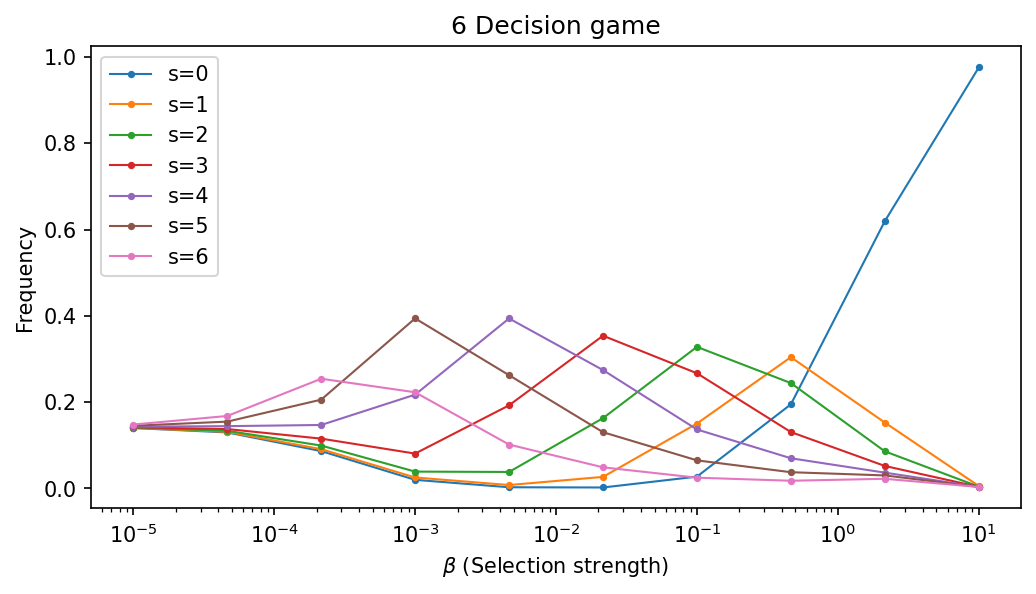

In [10]:
fig, ax = plt.subplots(figsize= (8,4), dpi=150)

ax.plot(betas, stationary_distributions, marker=".", markersize=5, linewidth=1,)
ax.legend(['s='+str(s) for s in range(nb_strategies)])
ax.set_xscale('log')
ax.set_xlabel(r'$\beta$ (Selection strength)')
ax.set_ylabel(r'Frequency')
ax.set_title(str(NB_STEPS)+' Decision game')
plt.show()

## As $\beta$ decreases, increasingly cooperative strategies are favored by natural selection over a range of payoff values - Figure 3

In [11]:
a1 = .4
a0 = .1
bs = np.linspace(1, 4, NB_DATAPOINTS)
betas = np.logspace(-5., 1., NB_DATAPOINTS) 

In [12]:
fig3 = np.zeros((NB_DATAPOINTS, NB_DATAPOINTS), dtype=float)

for i, b in enumerate(bs):
    payoff_matrix = get_payoff_matrix_symmetric(*get_payoffs(NB_STEPS, a1, a0, b))
    nb_strategies = len(payoff_matrix)
    game = Matrix2PlayerGameHolder(nb_strategies, payoff_matrix)
    evolver = PairwiseComparison(population_size=Z, game=game)
    for j, beta in enumerate(betas):
        transition_matrix, _ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        sd = calculate_stationary_distribution(transition_matrix.transpose())
        fig3[i,j] = np.argmax(sd)
                

/Users/marcosaponara/opt/anaconda3/envs/essaienv/lib/python3.12/site-packages/egttools/utils.py:215: RuntimeWarning: Some of the entries in the transition matrix are close to 1 (with a tolerance of 1e-11). This could result in more than one eigenvalue of magnitute 1 (the Markov Chain is degenerate), so please be careful when analysing the results.
  warn(


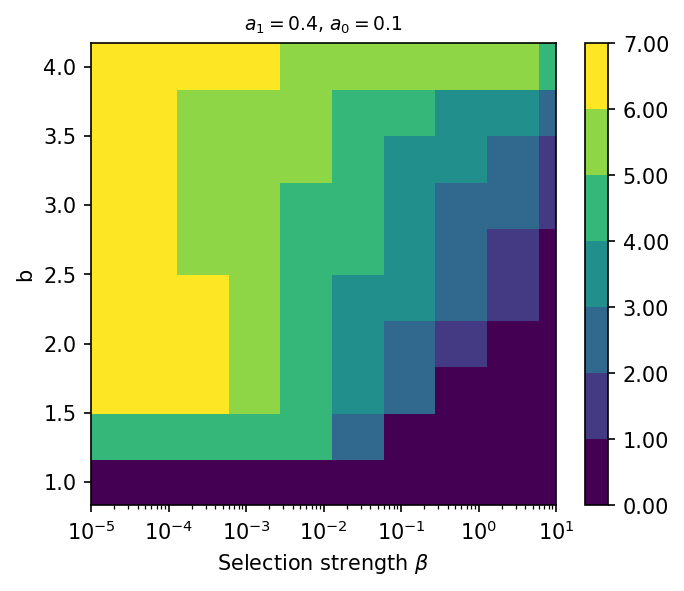

In [13]:
vmin=0
vmax=NB_STEPS+1

# Define the number of discrete colors
levels = MaxNLocator(nbins=vmax).tick_values(vmin, vmax)
# Define a colormap
cmap = plt.get_cmap('viridis')

# Define a normalization instance which maps data values to colors
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots(figsize= (5,4), dpi=150)
tmp = ax.pcolor(betas, bs, fig3, cmap=cmap, norm=norm,)
ax.set_xlabel(r'Selection strength $\beta$')
ax.set_ylabel(r'b')
ax.set_title(r'$a_1=$'+str(a1)+r', $a_0=$'+str(a0),fontsize=9)
ax.set_xscale('log')
ax.set_xlim(betas.min(), betas.max())

# Add a colorbar
cbar = fig.colorbar(tmp, ax=ax, ticks=levels, spacing='proportional')
cbar.ax.set_yticklabels([f'{level:.2f}' for level in levels])
plt.show()

## We ask whether the model can reproduce the frequency of each game length observed in the behavioral experiments - Figure 4

In [14]:
a1 = .4
a0 = .1
b = 2

payoff_matrix = get_payoff_matrix_symmetric(*get_payoffs(NB_STEPS, a1, a0, b))
nb_strategies = len(payoff_matrix)
game = Matrix2PlayerGameHolder(nb_strategies, payoff_matrix)

In [15]:
Zs = np.logspace(1, 4, NB_DATAPOINTS)
betas = np.logspace(-5,1, NB_DATAPOINTS)


In [16]:
mean_square_errors = np.zeros((NB_DATAPOINTS, NB_DATAPOINTS), dtype=float)

for i, Z in enumerate(Zs):
    evolver = PairwiseComparison(population_size=int(Z), game=game)
    for j, beta in enumerate(betas):
        transition_matrix, _ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        sd = calculate_stationary_distribution(transition_matrix.transpose())
        mean_square_errors[j,i] = ((sd - experimental_reference)**2).sum()

log_mean_square_errors = np.log10(mean_square_errors)

/Users/marcosaponara/opt/anaconda3/envs/essaienv/lib/python3.12/site-packages/egttools/utils.py:215: RuntimeWarning: Some of the entries in the transition matrix are close to 1 (with a tolerance of 1e-11). This could result in more than one eigenvalue of magnitute 1 (the Markov Chain is degenerate), so please be careful when analysing the results.
  warn(


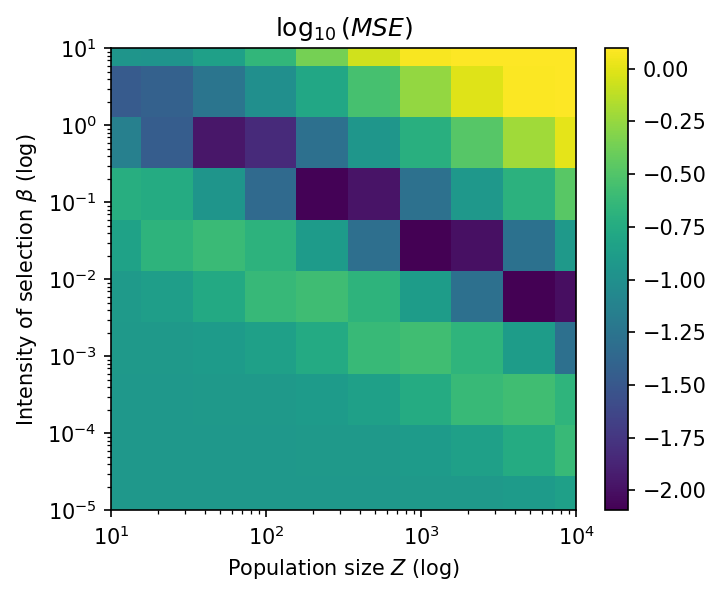

In [17]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150,)
tmp=ax.pcolor(Zs, betas, log_mean_square_errors, cmap='viridis',)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(Zs.min(), Zs.max())
ax.set_ylim(betas.min(), betas.max())
ax.set_xlabel(r'Population size $Z$ (log)')
ax.set_ylabel(r'Intensity of selection $\beta$ (log)')
ax.set_title(r'$\log_{10}(MSE)$')
fig.colorbar(tmp)
plt.show()

In [18]:
for i, Z in enumerate(Zs):
    idx_beta_best_fit = np.argmin(mean_square_errors[:, i])
    beta_best_fit = betas[idx_beta_best_fit]
    print("Best fit for population size "+str(int(Z))+r" is achieved at selection strength "+str(np.round(beta_best_fit, 3))+" with a MSE of "+str(np.round(mean_square_errors[idx_beta_best_fit,i],4)))

#

Best fit for population size 10 is achieved at selection strength 2.154 with a MSE of 0.0336
Best fit for population size 21 is achieved at selection strength 0.464 with a MSE of 0.0352
Best fit for population size 46 is achieved at selection strength 0.464 with a MSE of 0.0109
Best fit for population size 100 is achieved at selection strength 0.464 with a MSE of 0.0146
Best fit for population size 215 is achieved at selection strength 0.1 with a MSE of 0.0082
Best fit for population size 464 is achieved at selection strength 0.1 with a MSE of 0.0105
Best fit for population size 1000 is achieved at selection strength 0.022 with a MSE of 0.008
Best fit for population size 2154 is achieved at selection strength 0.022 with a MSE of 0.0098
Best fit for population size 4641 is achieved at selection strength 0.005 with a MSE of 0.008
Best fit for population size 10000 is achieved at selection strength 0.005 with a MSE of 0.0097


## Best fitting for $Z=1000$ - Figure 5

Finite population size analysis quantitatively reproduces human behavior from two laboratory experiments (McKelvey and Palfrey, 1992). Model predictions (Red) are generated using payoffs $a_1=0.4$, $a_0=0.1$ and $b=2$ and model parameters $N=1000$ and $\beta=0.03$.

In [19]:
Z = 1000
beta_best_fit = .03

# same game as before
evolver = PairwiseComparison(population_size=Z, game=game)
transition_matrix, _ = evolver.calculate_transition_and_fixation_matrix_sml(beta_best_fit)
sd = calculate_stationary_distribution(transition_matrix.transpose())

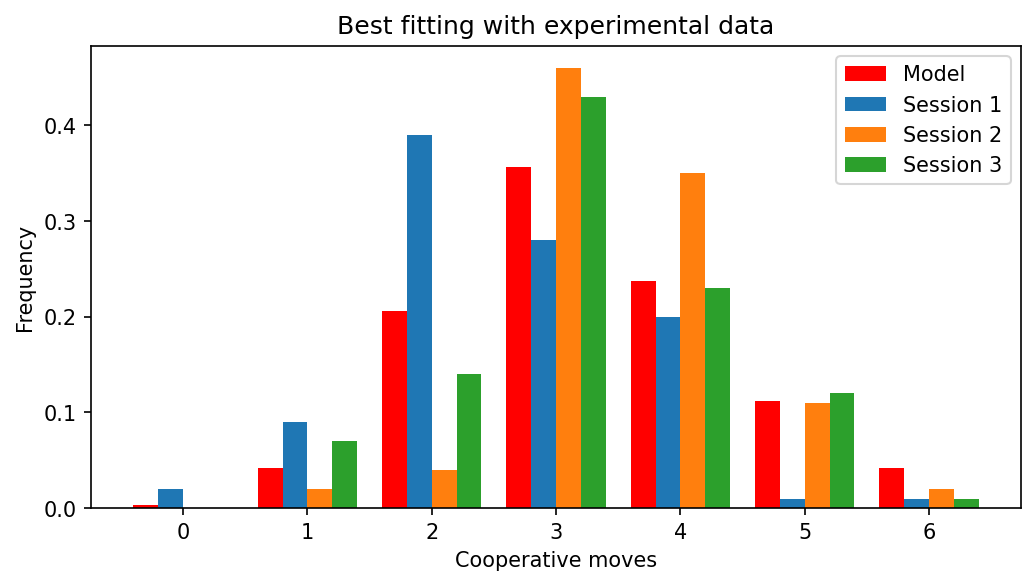

In [20]:
X = [str(t) for t in range(NB_STEPS + 1)]
X_axis = np.arange(len(X))

fig, ax = plt.subplots(figsize= (8,4), dpi=150)
ax.bar(X_axis - 0.3, sd, 0.2, label ='Model', color='red')
ax.bar(X_axis - 0.1, session1, 0.2, label = 'Session 1')
ax.bar(X_axis + 0.1, session2, 0.2, label = 'Session 2')
ax.bar(X_axis + 0.3, session3, 0.2, label = 'Session 3')
ax.set_xticks(X_axis, X)
ax.set_title('Best fitting with experimental data')
ax.set_xlabel('Cooperative moves')
ax.set_ylabel('Frequency')
plt.legend()
plt.show()

## Simulations - Figure 6

In [21]:
Z = 100
game = Matrix2PlayerGameHolder(nb_strategies, payoff_matrix)

numerical_evolver = PairwiseComparisonNumerical(pop_size = Z, 
                                              game = game,
                                              cache_size = 1000000,
                                             )

In [25]:
estimated_stationary_distribution = numerical_evolver.estimate_stationary_distribution(nb_runs = 10, 
                                                                                       nb_generations = int(50000), 
                                                                                       transitory = int(1.0e4), 
                                                                                       beta = .5, 
                                                                                       mu = 1e-3,
                                                                                      )

# estimated_stationary_distribution is an array of length nb_states where nb_states is the number of possible states of the system.
# A state can be defined by a vector of length nb_strategies of integers summing to Z:
# An example for 5 strategies and Z = 100: state = [50, 0, 20, 10, 20], 
# meaning 50 agents over 100 are playing strategy 0, 0 agents over 100 are playing strategy 1, and so on...
#
# We can then derive the frequency of the strategies from the estimated stationary distribution:

estimated_strategies_distribution = calculate_strategies_distribution(pop_size = Z,
                                                                     nb_strategies = nb_strategies,
                                                                     stationary_distribution = estimated_stationary_distribution)

In [26]:
print(estimated_strategies_distribution.sum())

0.9965524999999998


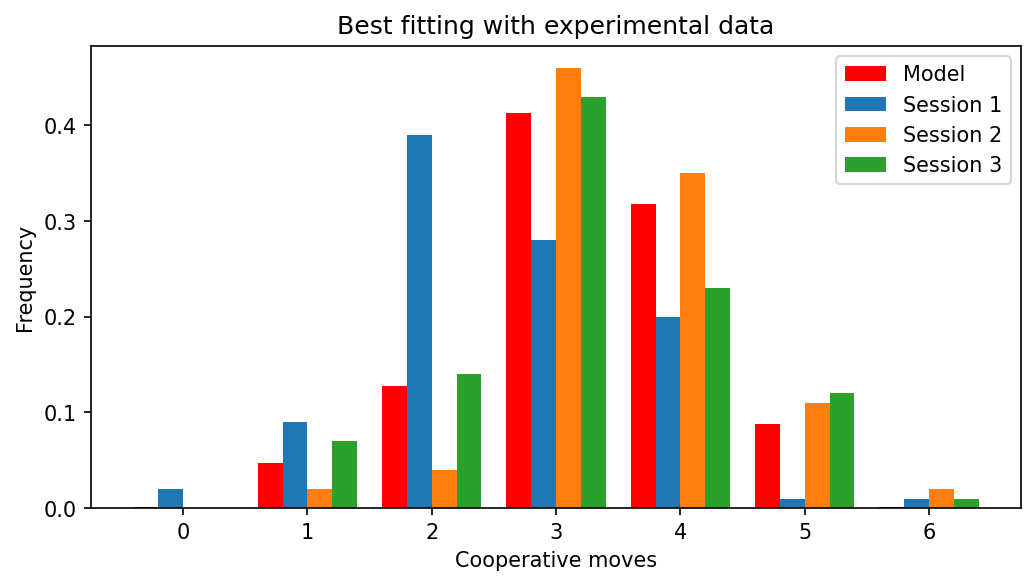

In [27]:
X = [str(t) for t in range(NB_STEPS + 1)]
X_axis = np.arange(len(X))

fig, ax = plt.subplots(figsize= (8,4), dpi=150)
ax.bar(X_axis - 0.3, estimated_strategies_distribution, 0.2, label ='Model', color='red')
ax.bar(X_axis - 0.1, session1, 0.2, label = 'Session 1')
ax.bar(X_axis + 0.1, session2, 0.2, label = 'Session 2')
ax.bar(X_axis + 0.3, session3, 0.2, label = 'Session 3')
ax.set_xticks(X_axis, X)
ax.set_title('Best fitting with experimental data')
ax.set_xlabel('Cooperative moves')
ax.set_ylabel('Frequency')
plt.legend()
plt.show()

Try to change the values of some parameters e.g., NB_STEPS = 4